In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import rc, font_manager
ticks_font = font_manager.FontProperties(family='serif', style='normal',
                                         size=24, weight='normal', stretch='normal')
import scipy.integrate as integrate
import scipy.optimize as optimize
from scipy import interpolate
import ternary

In [2]:
import copy 

In [3]:
# numpy
# pandas

class build_mesh_ternary:
##"build mesh grid for pseudo-ternary diagram"
# input is increment, and composition range for the pseudo ternary components
# generate evenly spaced concentration points for the pseudo ternary components (psA, psB, and psC)
# then for each pseudo ternary component, assign the elemental concentration according to the ratio

# e.g. psA = CoNi,
#      psA_elements: Co, Ni, 
#      psA_ratio: 1:1
#
    def __init__(self,increment,
                 psA_range,
                 psB_range,
                 psC_range,
                 psA_elements,
                 psB_elements,
                 psC_elements,
                 psA_ratio,
                 psB_ratio,
                 psC_ratio):
        if float(increment) <=0:
            print('error: increment should be positive float')
            quit()
        self.increment = float(increment)
        self.psA_range = psA_range
        self.psB_range = psB_range
        self.psC_range = psC_range
        
        self.psA_elements = psA_elements
        self.psB_elements = psB_elements
        self.psC_elements = psC_elements
        
        self.psA_ratio = np.array(psA_ratio)
        self.psB_ratio = np.array(psB_ratio)
        self.psC_ratio = np.array(psC_ratio)
        
        
    def make_mesh(self):
        self.comp_psA = []
        self.comp_psB = []
        self.comp_psC = []
        a1 = np.arange(0,100,self.increment);
        a1 = np.append(a1,100)
        for i in a1:
            a2 = np.arange(0,100-i,self.increment)
            a2 = np.append(a2,100-i)
            for j in a2:
                self.comp_psA.append(i)
                self.comp_psB.append(j)
                self.comp_psC.append(100-i-j)
        comp_tmp = pd.DataFrame(
            data={
                    "comp(psA)":self.comp_psA,
                    "comp(psB)":self.comp_psB,
                    "comp(psC)":self.comp_psC
                 })
        
        self.comp = comp_tmp[(comp_tmp['comp(psA)']>=self.psA_range[0]) & (comp_tmp['comp(psA)']<=self.psA_range[1])
                            &(comp_tmp['comp(psB)']>=self.psB_range[0]) & (comp_tmp['comp(psB)']<=self.psB_range[1])
                            &(comp_tmp['comp(psC)']>=self.psC_range[0]) & (comp_tmp['comp(psC)']<=self.psC_range[1])]
        
        return self.comp
    
    def comp_assign(self):
    # assign psA to psA_elements according to psA_ratio
    # assign psB to psB_elements according to psB_ratio
    # assign psC to psC_elements according to psC_ratio
    # e.g. 
    # if psA_elements = ['Co','Ni','Cr'], psA_ratio = [1,1,2]
    # when psA = 40 at.%, Co = 10 at.%, Ni = 10 at.%, Cr = 20 at.%
        self.comp_elements = pd.DataFrame(data={})
        self.comp_psA_elements = [self.comp['comp(psA)']*self.psA_ratio[i]/sum(self.psA_ratio) for i in range(len(self.psA_ratio))]
        self.comp_psB_elements = [self.comp['comp(psB)']*self.psB_ratio[i]/sum(self.psB_ratio) for i in range(len(self.psB_ratio))]
        self.comp_psC_elements = [self.comp['comp(psC)']*self.psC_ratio[i]/sum(self.psC_ratio) for i in range(len(self.psC_ratio))]
        
        for i in range(len(self.psA_elements)):
            self.comp[self.psA_elements[i]] = self.comp_psA_elements[i]
            self.comp_elements[self.psA_elements[i]] = self.comp_psA_elements[i]
        for i in range(len(self.psB_elements)):
            self.comp[self.psB_elements[i]] = self.comp_psB_elements[i]
            self.comp_elements[self.psB_elements[i]] = self.comp_psB_elements[i]
        for i in range(len(self.psC_elements)):
            self.comp[self.psC_elements[i]] = self.comp_psC_elements[i]
            self.comp_elements[self.psC_elements[i]] = self.comp_psC_elements[i]
        
        self.comp_new = self.comp.reset_index(drop=True)
        self.comp_elements_new = self.comp_elements.reset_index(drop=True)
        return self.comp_new, self.comp_elements_new

In [180]:
import os
import json

class read_json_Suzuki_model_RWASM_ternary:
    
    def __init__(self,fh):
        if os.path.isfile(fh):
            self.file = fh
            self.data = json.load(open(fh))
        else:
            print('input file not in current directory')
            quit()
        
        self.model = self.data["model"]
        self.name = self.data["material"]
        # properties
        self.element_data = self.data['elements']
        # adjustable scalers
        self.adjustable_scalers = self.data['adjustables']
        # exp conditions
        self.conditions = self.data['conditions']
        # output file
        try: 
            self.savefilename = self.data['savefile']
        except:
            self.savefilename = self.data["material"] + '_out'
        # ternary 
        self.psA_elements = self.data['pseudo-ternary']['psA']['grouped_elements']
        self.psB_elements = self.data['pseudo-ternary']['psB']['grouped_elements']
        self.psC_elements = self.data['pseudo-ternary']['psC']['grouped_elements']
        
        self.psA_ratio = self.data['pseudo-ternary']['psA']['ratio']
        self.psB_ratio = self.data['pseudo-ternary']['psB']['ratio']
        self.psC_ratio = self.data['pseudo-ternary']['psC']['ratio']
        
        self.psA_range = self.data['pseudo-ternary']['psA']['range']
        self.psB_range = self.data['pseudo-ternary']['psB']['range']
        self.psC_range = self.data['pseudo-ternary']['psC']['range']
        
        self.increment = self.data['pseudo-ternary']['increment']
        # check if liquidus tempratures are supplied
        try:
            self.T_l_tag = self.data['TC_data']['T_liquidus']
            if self.T_l_tag == 'tc_liquidus_wrapper':
                print('Will calculate liquidus temperatures from TC-Python.')
                print('Make sure to run with desired TC database. use TC_database tag under TC_data. ')
                try: 
                    self.tcdatabase = self.data['TC_data']['TC_database']
                    print('current database: {}'.format(self.data['TC_data']['TC_database']))
                except:
                    self.tcdatabase = 'TCHEA4'
                    print('current database: TCHEA4 (default)')

            else:
                try:
                    T_l_df = pd.read_csv(self.T_l_tag)
                    self.T_l = T_l_df['T_liquidus']
                    print('Getting liquidus temperatures from file {}'.format(self.T_l_tag))
                except: 
                    self.T_l = None
                    print('Cannot read the file {}, be sure it is .csv format containing the \'T_liquidus\' '.format(self.T_l_tag))
        except:
            self.T_l = None
            self.T_l_tag = None
        
        
                

In [213]:
class Suzuki_model_RWASM_ternary:
    
    def __init__(self,
                inputdata,
                comp_elements,comp_pst,
                T_l = None):
        
        
        self.element_composition = comp_elements
        self.element_data = inputdata.element_data
        self.comp_pst = comp_pst
        if T_l is None:
            print('no Tl (liquidus temperature) supplied, cannot predict high-temperature jog-dragging mode.')
            self.T_l = np.ones(len(self.element_composition))*1e8
        else:
            self.T_l = T_l
        # 
        
        # conditions
        self.strain_r = inputdata.conditions['strain_r']
        self.T_range = np.arange(inputdata.conditions['temperature']['min'],
                           inputdata.conditions['temperature']['max']+inputdata.conditions['temperature']['inc'],
                           inputdata.conditions['temperature']['inc'])
        
        # constants
        self.boltzmann_J = 1.380649e-23
        self.boltzmann_eV = 8.617333262145e-5
        self.J2eV = self.boltzmann_eV/self.boltzmann_J
        self.eV2J = 1/self.J2eV
        self.Debye = 5 * 10**(12) # Debye frequency /s

        #adjustables
        self.rho = inputdata.adjustable_scalers['dislocation_density']
        self.tau_i_exponent = inputdata.adjustable_scalers['tau_i_exponent']
        self.trial_kappa_range = np.arange(inputdata.adjustable_scalers['trial_kappa']['min'],
                                          inputdata.adjustable_scalers['trial_kappa']['max']+inputdata.adjustable_scalers['trial_kappa']['inc'],
                                          inputdata.adjustable_scalers['trial_kappa']['inc'])
        self.trial_tau_k = inputdata.adjustable_scalers['trial_tau_k'] * 1e6
        self.kink_width = inputdata.adjustable_scalers['kink_width']

        
        
    def L(self,kappa_i):
        f = lambda x: np.exp(-x**2/2)/np.sqrt(2*np.pi)
        y = integrate.quad(f,kappa_i,np.inf)
        return self.b/(3*y[0]*self.c) 
        
    def tau_j(self,kappa_i):
        
        try: 
            liquidus_T = self.T_l[self.composition_idx]
        except:
            # if cannot read self.T_l[self.composition_idx] for that composition
            # assign a very high liquidus_T -> this will make jog mode impossible
            liquidus_T = 1e8
        Q = 19.12*self.boltzmann_J*liquidus_T
        D = 14*self.Debye*self.b**2 * np.exp(-Q/self.kT)
        time = 0.002/self.strain_r
        if np.sqrt(D*time) >= self.b:
            self.jog = True
            st = self.strain_r/(2.598*np.pi*self.rho*D)
            tau_j = (self.kT/(2*self.L(kappa_i)*self.b**2)) * np.log(st + np.sqrt(1+st**2) )
        else:
            self.jog = False
            tau_j = (self.E_int + self.E_vac)/(4*self.b*self.L(kappa_i))

        return tau_j
    
    def tau_y_k_j(self,tau_k_trial,kappa_i_list):

        self.Delta_V = lambda tau_k_trial,kappa_i: 3 * kappa_i**2 * self.E_w**2 * self.c / (2*tau_k_trial**2*self.a_p*self.b**2) + \
                                     tau_k_trial**2 * self.a_p**3 * self.b**4 * self.lambda_k**2 / (6*kappa_i**2 * self.E_w**2 * self.c)
        self.S = lambda tau_k_trial,kappa_i: 18 * kappa_i**2 * self.E_w**2 * self.c *self.kT /(self.a_p**3 * self.b**4 * self.lambda_k**2) * \
                 np.log( (5*np.pi*self.kT)**2 * self.Debye * self.a_p * self.b /((self.G*self.b*self.Delta_V(tau_k_trial,kappa_i))**2 * self.strain_r) )
        self.R = lambda kappa_i: 27 * kappa_i**4 * self.E_w**4 * self.c**2 / (self.a_p**4 * self.b**6 * self.lambda_k**2)

        self.tau_k_func = lambda tau_k_trial,kappa_i: tau_k_trial**4 + tau_k_trial*self.S(tau_k_trial,kappa_i) - self.R(kappa_i) 
        self.tau_k_kappa = []
        self.tau_j_kappa = []
        self.tau_y_kappa = []
        for kappa_i in kappa_i_list:
            self.res = optimize.root(self.tau_k_func, tau_k_trial, args=(kappa_i,))
            self.tau_k_kappa.append(self.res.x[0])
            self.tau_j_kappa.append(self.tau_j(kappa_i))
            self.tau_y_kappa.append(self.res.x[0] + self.tau_j(kappa_i))
        
    
    def phenomelogical_model_tau_y(self): 
        # tau_y = ( sum( tau_y_i**(1/q) ) )**q
        self.tau_y_tot = [sum(tau_y_i**(1/self.tau_i_exponent))**self.tau_i_exponent for tau_y_i in self.tau_y_i_pst]
        
    def calculate(self):
        self.calc_data_all = {}
        for T in self.T_range:
            self.T = T
            self.kT = self.boltzmann_J * self.T
            self.tau_y_i_pst = [] # record all compositions shape(len(composition),len(element))
            tau_y_i_pst = []
            self.jog_i = []
            for i in range(len(self.element_composition)):
                self.composition_idx = i
                # record tau_y for every element at composition i
                tau_y_i = []
                for element_symbol in self.element_composition.columns:
                    element_i = self.element_data[element_symbol]
                    #print(element_i)
                    # calculate the yield strength contribution for every element
                    # according to concentration
                    # setup properties for every element
                    self.c = self.element_composition[element_symbol][i]/100
                    if self.c == 0:
                        tau_y_i.append(0)
                        continue
                    self.E_f_v = element_i['E_f_v'] * self.eV2J #J
                    self.E_f_si = element_i['E_f_si'] * self.eV2J # J
                    self.a_0 = element_i['a']*1e-10#element_i['a_0'] * 10**(-10) # unit: m
                    self.E_w = element_i['E_w_i'] * self.eV2J#element_i['E_w'] * self.eV2J # J

                    self.G = element_i['G'] * 10**9 # Pa
                    self.nu = element_i['nu']
                    self.b = self.a_0 * np.sqrt(3) / 2
                    self.a_p = self.a_0 * np.sqrt(2/3)
                    #self.E_vac = 0.6 * self.eV2J / 10**(-10) # test NbTiZr
                    #self.E_int = 0.9 * self.eV2J / 10**(-10) # test NbTiZr
                    self.E_vac = 0.707 * self.E_f_v  /self.b + self.G * self.b**2 / (np.pi*(1-self.nu)) * np.log(1.5)
                    self.E_int = 0.707 * self.E_f_si /self.b + self.G * self.b**2 / (np.pi*(1-self.nu)) * np.log(1.5)
                    self.lambda_k = self.b * self.kink_width

                    # record the optimization results for post-processing
                    tau_k_list = []
                    tau_j_list = []
                    tau_y_list = []
                    optimized_kappa_list = []

                    # start to optimize tau_k for every trial kappa
                    self.tau_y_k_j(self.trial_tau_k, self.trial_kappa_range)
                    tau_k_list = np.array(self.tau_k_kappa)/1e6
                    tau_j_list = np.array(self.tau_j_kappa)/1e6
                    tau_y_list = np.array(self.tau_y_kappa)/1e6
                    kappa_list = self.trial_kappa_range

                    # optimize tau_y over kappa, this finds the true tau_y for each element
                    kappa_sort, tau_y_sort, tau_j_sort, tau_k_sort  = zip(*sorted(zip(kappa_list, tau_y_list, tau_j_list, tau_k_list)))
                    ###
                    polyfit = np.polyfit(kappa_sort,tau_y_sort,4)
                    npfit = np.poly1d(polyfit)
                    guess_kappa = (self.trial_kappa_range[0]+self.trial_kappa_range[1])/2
                    res = optimize.fmin_slsqp(npfit,guess_kappa,
                                              bounds=([(self.trial_kappa_range[0],self.trial_kappa_range[-1])]),
                                              iprint=-1)
                    optimized_kappa = res[0]
                    tau_y_i.append(npfit(optimized_kappa))

                self.tau_y_i = np.array(tau_y_i)

                self.jog_i.append(self.jog)
                
                tau_y_i_pst.append(self.tau_y_i)
            self.tau_y_i_pst = np.array(tau_y_i_pst)
            self.phenomelogical_model_tau_y()
            # record data for temperature
            self.calc_data = copy.deepcopy(self.comp_pst)
            for idx in range(len(self.element_composition.columns)):
                # elemental contribution to tau_y
                self.calc_data['tau_y_'+self.element_composition.columns[idx]] = np.round(self.tau_y_i_pst.transpose()[idx],2)
            self.calc_data['T'] = np.ones(len(self.calc_data)) * self.T
            self.calc_data['tau_y'] = np.round(self.tau_y_tot,2)
            self.calc_data['T_liquidus'] = self.T_l
            self.calc_data[self.calc_data['T_liquidus']==1e8]['T_liquidus']=np.nan
            self.calc_data['Jog_mode'] = self.jog_i
            self.calc_data_all[str(self.T)] = self.calc_data

    def writedata(self,foutname):
        for key_i in self.calc_data_all.keys():
            calc_data = self.calc_data_all[key_i]
            outputfile = foutname+'_'+str(key_i)
            calc_data.to_csv(outputfile,index=False,sep='\t',float_format='%.2f')
            print('-------------------------------Data Saved to {}-------------------------------'.format(outputfile))





In [214]:
input_data = read_json_Suzuki_model_RWASM_ternary('../sample_input_TiNbZr_BCC_screw_suzuki_ternary.json')


Getting liquidus temperatures from file NbTiZr_TCHEA4.csv


In [215]:

mesh = build_mesh_ternary(input_data.increment,
                          input_data.psA_range,
                          input_data.psB_range,
                          input_data.psC_range,
                          input_data.psA_elements,
                          input_data.psB_elements,
                          input_data.psC_elements,
                          input_data.psA_ratio,
                          input_data.psB_ratio,
                          input_data.psC_ratio)
comp_tmp = mesh.make_mesh()
comp_pst, comp_elements = mesh.comp_assign()
comp_pst

,comp(psA),comp(psB),comp(psC),Nb,Ti,Zr
0,0.0,0.0,100.0,0.0,0.0,100.0
1,0.0,5.0,95.0,0.0,5.0,95.0
2,0.0,10.0,90.0,0.0,10.0,90.0
3,0.0,15.0,85.0,0.0,15.0,85.0
4,0.0,20.0,80.0,0.0,20.0,80.0
...,...,...,...,...,...,...
226,90.0,5.0,5.0,90.0,5.0,5.0
227,90.0,10.0,0.0,90.0,10.0,0.0
228,95.0,0.0,5.0,95.0,0.0,5.0
229,95.0,5.0,0.0,95.0,5.0,0.0


In [216]:
model = Suzuki_model_RWASM_ternary(
                input_data,
                comp_elements,comp_pst,
                T_l = input_data.T_l
                )

In [217]:
input_data.element_data

{'Nb': {'a': 3.3,
  'G': 38,
  'nu': 0.4,
  'E_w_i': 0.054,
  'E_f_v': 2.99,
  'E_f_si': 5.25},
 'Ti': {'a': 3.31,
  'G': 44,
  'nu': 0.32,
  'E_w_i': -0.028,
  'E_f_v': 2.22,
  'E_f_si': 2.4},
 'Zr': {'a': 3.58,
  'G': 33,
  'nu': 0.34,
  'E_w_i': -0.053,
  'E_f_v': 1.8,
  'E_f_si': 3.5}}

In [195]:
model.calculate()

In [196]:
model.writedata('xxx')

-------------------------------Data Saved to xxx_1000-------------------------------
-------------------------------Data Saved to xxx_1100-------------------------------
-------------------------------Data Saved to xxx_1200-------------------------------


In [200]:
mask=model.calc_data['Jog_mode']==True
model.calc_data[mask]

,comp(psA),comp(psB),comp(psC),Nb,Ti,Zr,tau_y_Nb,tau_y_Ti,tau_y_Zr,T,tau_y,T_liquidus,Jog_mode
3,0.0,15.0,85.0,0.0,15.0,85.0,0.00,7.18,73.32,1200.0,80.50,2020.43,True
4,0.0,20.0,80.0,0.0,20.0,80.0,0.00,9.17,67.58,1200.0,76.75,1987.97,True
5,0.0,25.0,75.0,0.0,25.0,75.0,0.00,11.02,61.94,1200.0,72.97,1957.59,True
6,0.0,30.0,70.0,0.0,30.0,70.0,0.00,12.75,56.43,1200.0,69.17,1929.56,True
7,0.0,35.0,65.0,0.0,35.0,65.0,0.00,14.35,51.07,1200.0,65.41,1904.20,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,30.0,0.0,70.0,30.0,0.0,70.0,36.78,0.00,62.01,1200.0,98.79,2042.35,True
112,30.0,5.0,65.0,30.0,5.0,65.0,36.67,2.63,57.66,1200.0,96.97,2037.66,True
113,30.0,10.0,60.0,30.0,10.0,60.0,36.63,4.98,53.43,1200.0,95.05,2036.08,True
114,30.0,15.0,55.0,30.0,15.0,55.0,36.66,7.25,49.28,1200.0,93.19,2037.09,True


In [201]:
points = model.calc_data[model.calc_data.columns[:3]].apply(tuple, axis=1)
heatmap_dict =  dict(zip(points, np.round(model.calc_data['tau_y'],2)))


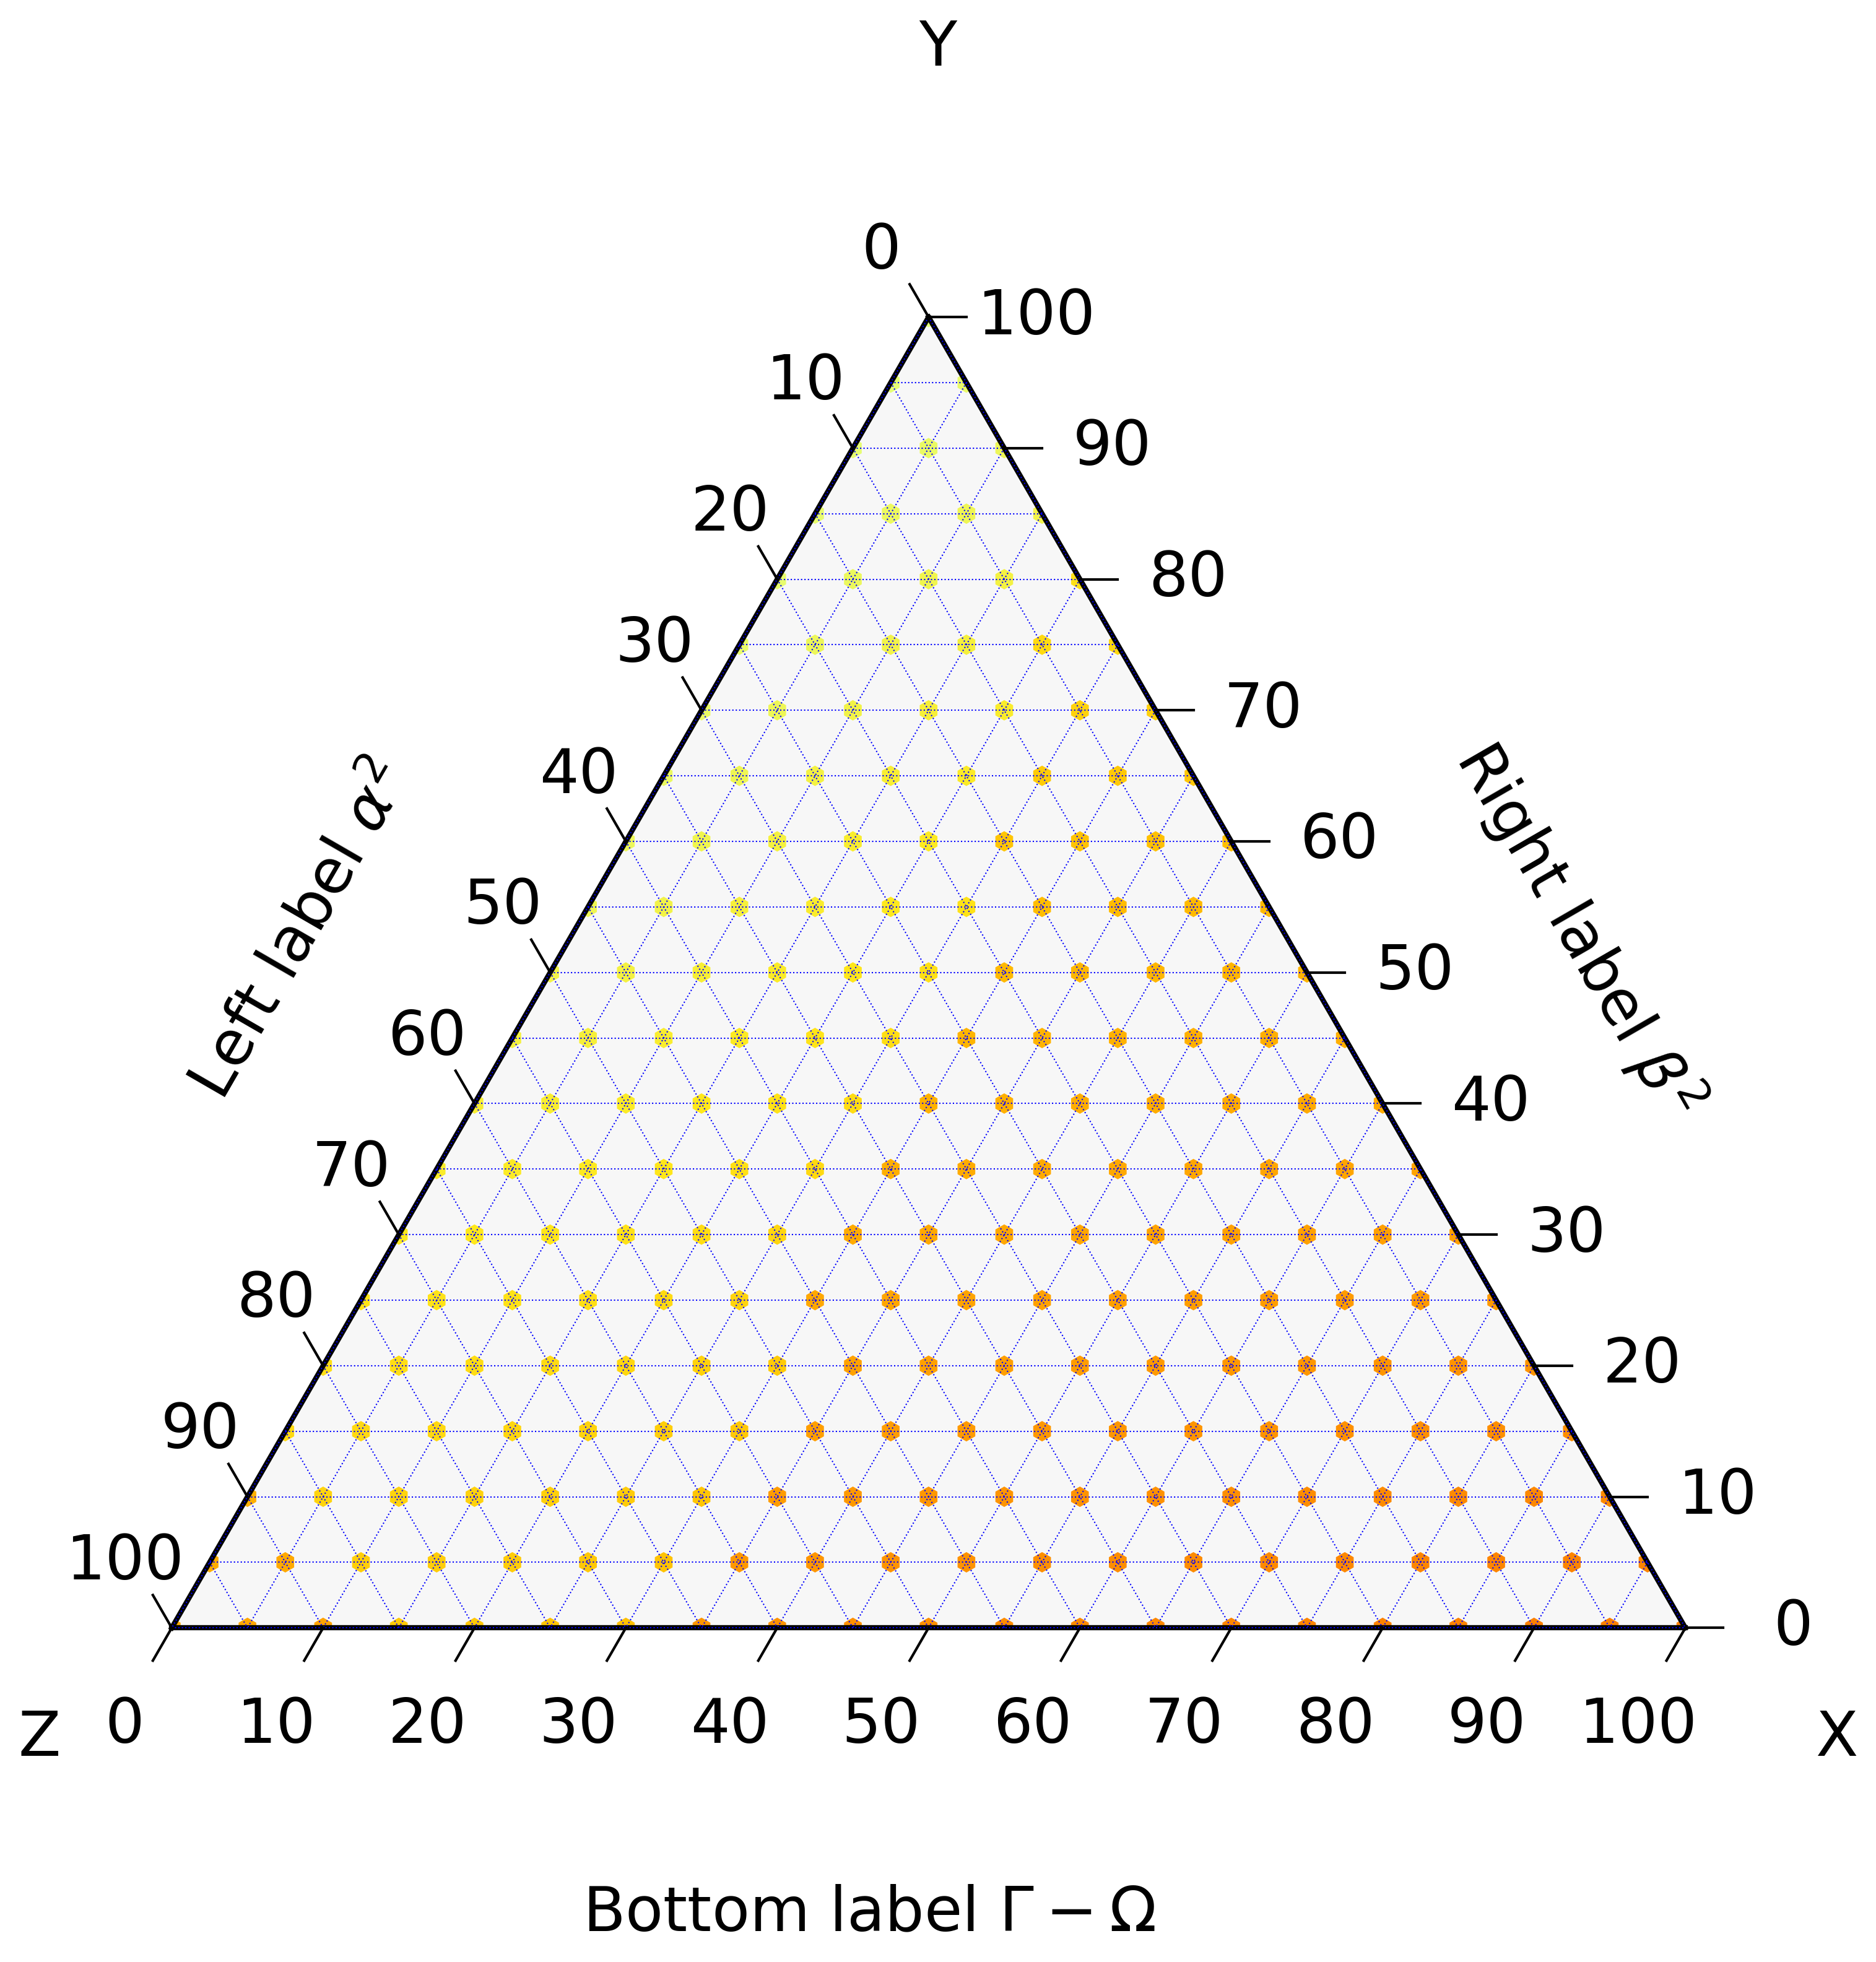

In [202]:
fig = ternary.plt.figure(figsize=(12,12),dpi=300)
ax1 = fig.add_subplot(1, 1, 1)


tax = ternary.TernaryAxesSubplot(ax=ax1, scale=100)
tax.boundary(linewidth=2.0)
tax.gridlines(color="blue", multiple=5)

fontsize = 24
offset = 0.16

tax.right_corner_label("X", fontsize=fontsize) 
tax.top_corner_label("Y", fontsize=fontsize)
tax.left_corner_label("Z", fontsize=fontsize)


tax.left_axis_label("Left label $\\alpha^2$", fontsize=fontsize, offset=offset)
tax.right_axis_label("Right label $\\beta^2$", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("Bottom label $\\Gamma - \\Omega$", fontsize=fontsize, offset=offset)


#tax.plot(points, marker='.', color='red', label="Red Squares")
cmap='Wistia'
tax.heatmap(heatmap_dict,
            cmap=cmap,
            colorbar=False,
            vmin=min(model.calc_data['tau_y']),
            vmax=max(model.calc_data['tau_y']),
            style='hexagonal')



tax.ticks(axis='lbr', multiple=10, linewidth=1, offset=0.025,fontsize=fontsize)
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()
tax.resize_drawing_canvas()
tax.ax.axis("equal")
tax.show()

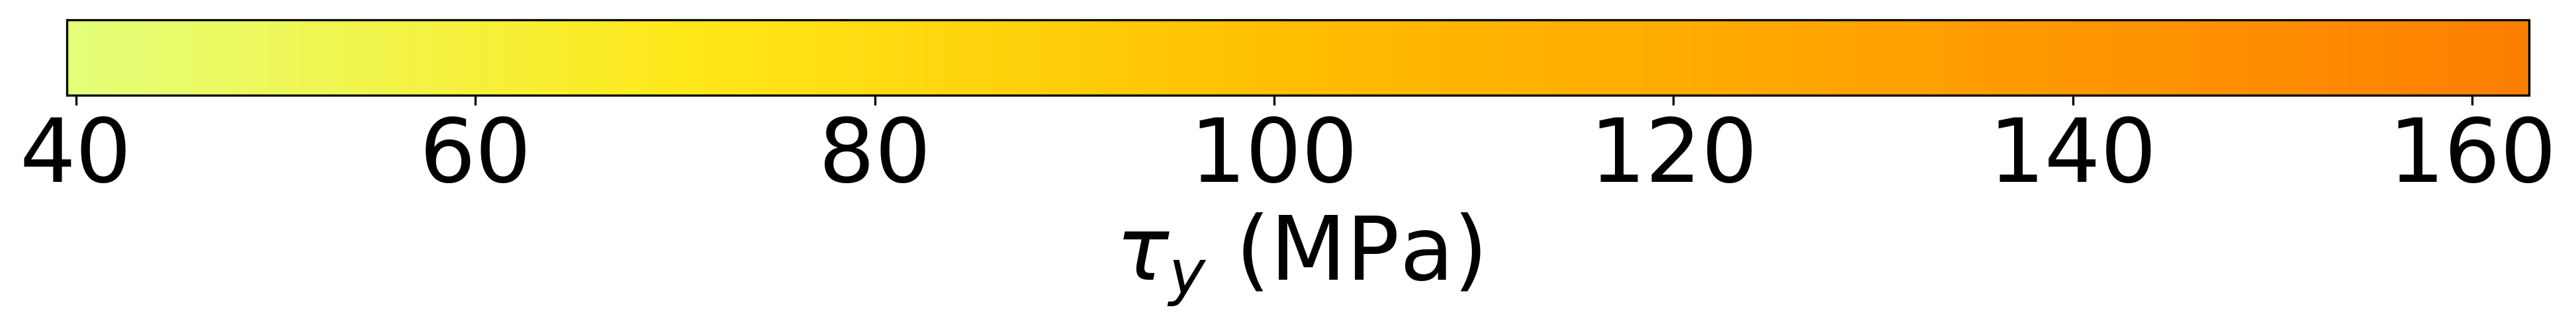

In [203]:
fig, ax = plt.subplots(figsize=(16, 1),dpi=300)
fig.subplots_adjust(bottom=0.5)
norm = mpl.colors.Normalize(vmin=min(model.calc_data['tau_y']),
                            vmax=max(model.calc_data['tau_y']))
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal')
cb.set_label(label=r'$\tau_{y}$ (MPa)',size=32)
cb.ax.tick_params(labelsize=32)

In [40]:
import plotly.express as px

In [208]:
# concatenate the two datasets and plot
all_data_df = pd.concat([model.calc_data_all['1000'],model.calc_data_all['1100'],model.calc_data_all['1200']])
all_data_df["T"] = all_data_df["T"].astype(str)
fig = px.scatter_3d(all_data_df, x='Nb', y='Ti', z='tau_y',color='T')

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.update_layout(scene_aspectmode='cube')
fig.show()

In [207]:
fig = px.scatter_3d(model.calc_data, x='Nb', y='Ti', z='T_liquidus')

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.update_layout(scene_aspectmode='cube')
fig.show()